In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/processed/games_with_features.csv')
print(f"Loaded {len(data)} games")
print(f"Columns: {data.columns.tolist()}")


Loaded 26502 games
Columns: ['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'pts_avg_10_home', 'fg_pct_avg_10_home', 'ft_pct_avg_10_home', 'fg3_pct_avg_10_home', 'ast_avg_10_home', 'reb_avg_10_home', 'pts_avg_10_away', 'fg_pct_avg_10_away', 'ft_pct_avg_10_away', 'fg3_pct_avg_10_away', 'ast_avg_10_away', 'reb_avg_10_away', 'rest_days_home', 'rest_days_away', 'back_to_back_home', 'back_to_back_away', 'league_home_advantage', 'target']


In [30]:
metadata_cols = ['GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'target', 'GAME_ID']
feature_cols = [col for col in data.columns if col not in metadata_cols]

X = data[feature_cols]
y = data['target']

print(f"\nFeatures ({len(feature_cols)}):")
for f in feature_cols:
    print(f"  • {f}")


Features (17):
  • pts_avg_10_home
  • fg_pct_avg_10_home
  • ft_pct_avg_10_home
  • fg3_pct_avg_10_home
  • ast_avg_10_home
  • reb_avg_10_home
  • pts_avg_10_away
  • fg_pct_avg_10_away
  • ft_pct_avg_10_away
  • fg3_pct_avg_10_away
  • ast_avg_10_away
  • reb_avg_10_away
  • rest_days_home
  • rest_days_away
  • back_to_back_home
  • back_to_back_away
  • league_home_advantage


In [31]:
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\n{'='*60}")
print(f"DATA SPLIT")
print(f"{'='*60}")
print(f"Training: {len(X_train)} games ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:     {len(X_test)} games ({len(X_test)/len(X)*100:.1f}%)")
print(f"Train home win rate: {y_train.mean():.3f}")
print(f"Test home win rate:  {y_test.mean():.3f}")


DATA SPLIT
Training: 21201 games (80.0%)
Test:     5301 games (20.0%)
Train home win rate: 0.597
Test home win rate:  0.556


In [32]:
baseline_acc = y_test.mean()  # Always predict home team wins

print(f"\n{'='*60}")
print(f"BASELINE (always predict home win): {baseline_acc:.3f}")
print(f"{'='*60}")



BASELINE (always predict home win): 0.556


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# ============================================
# Train Multiple Models
# ============================================

models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20, random_state=42, n_jobs=-1)
}

results = []

print(f"\n{'='*60}")
print(f"MODEL COMPARISON")
print(f"{'='*60}")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    # Store results
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Overfitting': train_acc - test_acc,
        'vs Baseline': test_acc - baseline_acc
    })
    
    print(f"  Train: {train_acc:.3f} | Test: {test_acc:.3f}")

# ============================================
# Display Results Table
# ============================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(results_df.to_string(index=False))
print(f"{'='*60}")
print(f"Baseline Accuracy: {baseline_acc:.3f}")
print(f"{'='*60}")

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_test_acc = results_df.iloc[0]['Test Accuracy']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.3f}")
print(f"   Improvement over baseline: +{best_test_acc - baseline_acc:.3f}")


MODEL COMPARISON

Training Logistic Regression...
  Train: 0.614 | Test: 0.583

Training Decision Tree...
  Train: 0.672 | Test: 0.556

Training Random Forest...
  Train: 0.702 | Test: 0.586

FINAL RESULTS
              Model  Train Accuracy  Test Accuracy  Overfitting  vs Baseline
      Random Forest        0.701571       0.585550     0.116021     0.029051
Logistic Regression        0.614122       0.582532     0.031590     0.026033
      Decision Tree        0.671902       0.555933     0.115969    -0.000566
Baseline Accuracy: 0.556

🏆 Best Model: Random Forest
   Test Accuracy: 0.586
   Improvement over baseline: +0.029


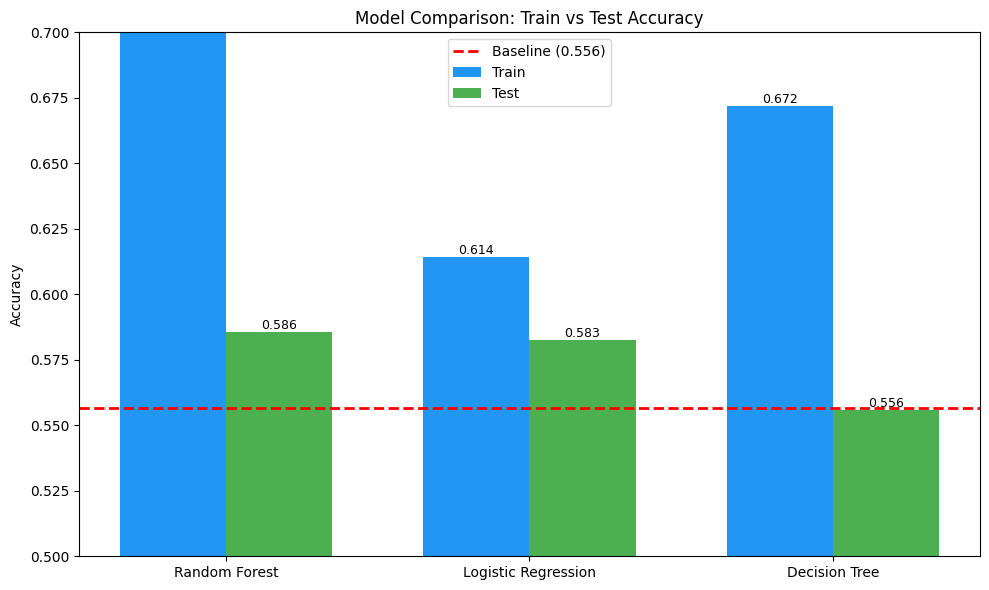


✓ Model comparison saved as 'model_comparison.png'


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# Model Comparison Chart
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Train Accuracy'], width, label='Train', color='#2196F3')
bars2 = ax.bar(x + width/2, results_df['Test Accuracy'], width, label='Test', color='#4CAF50')

# Baseline reference line
ax.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc:.3f})')

ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Train vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.set_ylim(0.5, 0.7)  # Adjust based on your results

# Add value labels on bars
for bar in bars1:
    ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison saved as 'model_comparison.png'")



EXTRACTING FEATURE IMPORTANCE FROM ALL MODELS
✓ Extracted importances/coefficients from all models

FEATURE IMPORTANCE COMPARISON (ALL MODELS)
              feature  importance_rf  importance_dt  importance_lr  lr_coefficient  avg_importance
   fg_pct_avg_10_home       0.135339       0.159676       0.383346        5.911967        0.226120
   fg_pct_avg_10_away       0.107872       0.141400       0.289357       -4.462473        0.179543
  fg3_pct_avg_10_away       0.074785       0.084389       0.096832       -1.493342        0.085335
  fg3_pct_avg_10_home       0.071950       0.056456       0.079457        1.225384        0.069287
   ft_pct_avg_10_away       0.067144       0.080878       0.053493       -0.824965        0.067171
   ft_pct_avg_10_home       0.063921       0.060673       0.048682        0.750770        0.057759
      reb_avg_10_away       0.064834       0.090706       0.002356       -0.036330        0.052632
      reb_avg_10_home       0.071978       0.077495       0.0026

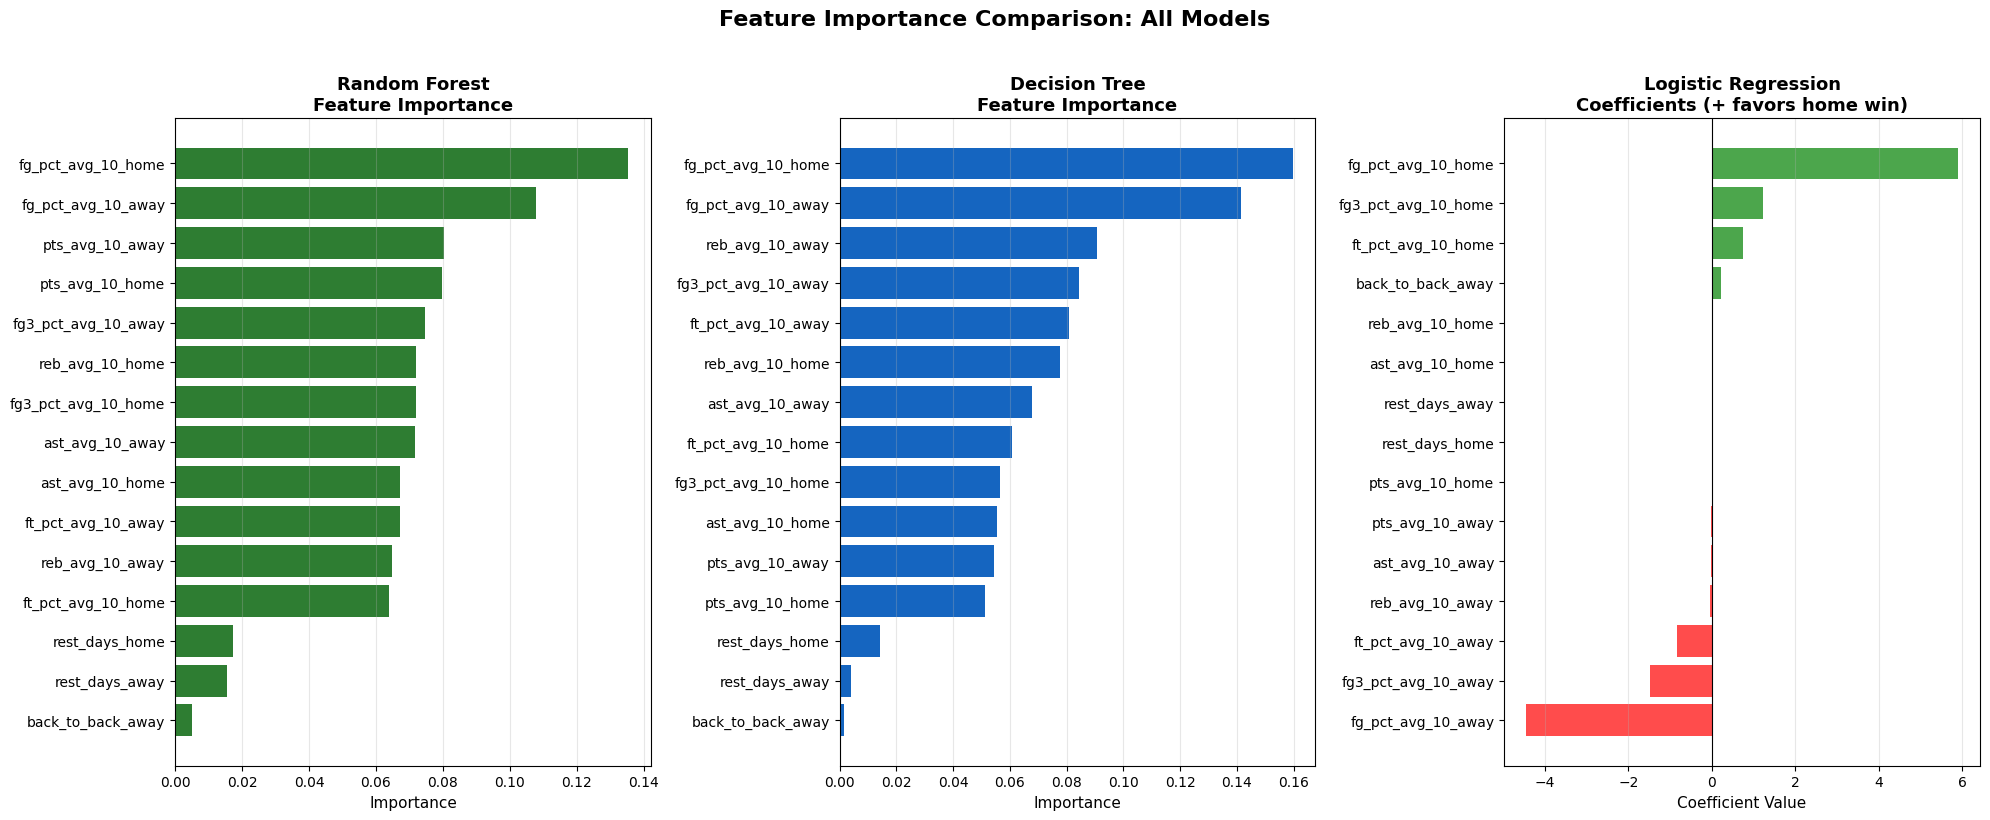


✓ Three-way comparison chart saved as 'feature_importance_all_models.png'


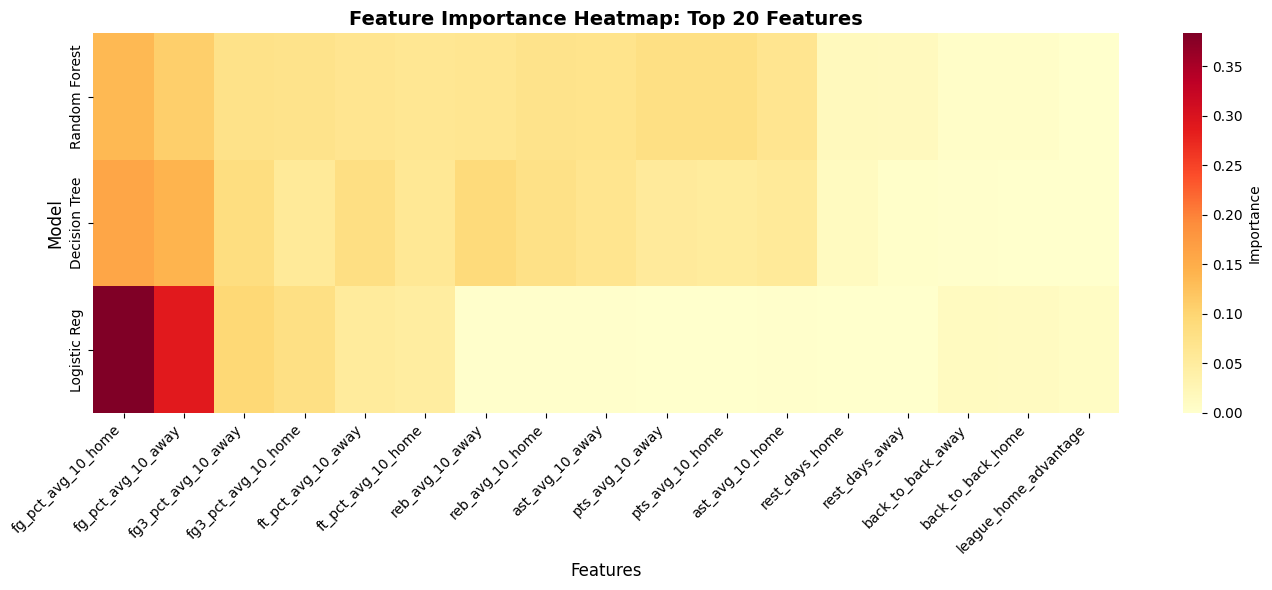

✓ Heatmap saved as 'feature_importance_heatmap.png'

MODEL AGREEMENT ANALYSIS

Pairwise Correlations:
  RF ↔ DT: 0.937
  RF ↔ LR: 0.673
  DT ↔ LR: 0.779

  Average correlation: 0.796
  ✅ High agreement across all models


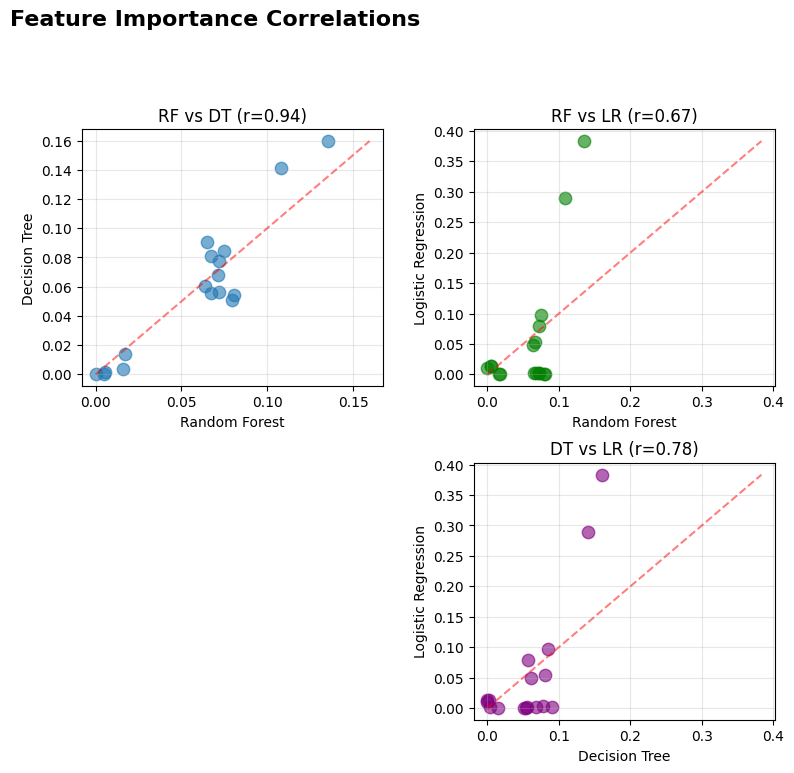


✓ Correlation scatter plots saved as 'importance_correlations.png'

FEATURES WITH HIGHEST AGREEMENT (Low Variability)
            feature  importance_rf  importance_dt  importance_lr  std_across_models
 ft_pct_avg_10_home       0.063921       0.060673       0.048682           0.008027
     rest_days_home       0.017349       0.014182       0.000776           0.008798
fg3_pct_avg_10_away       0.074785       0.084389       0.096832           0.011054
fg3_pct_avg_10_home       0.071950       0.056456       0.079457           0.011729
 ft_pct_avg_10_away       0.067144       0.080878       0.053493           0.013692
    ast_avg_10_home       0.067267       0.055566       0.001800           0.034913

FEATURES WITH HIGHEST DISAGREEMENT (High Variability)
            feature  importance_rf  importance_dt  importance_lr  std_across_models
 fg_pct_avg_10_home       0.135339       0.159676       0.383346           0.136704
 fg_pct_avg_10_away       0.107872       0.141400       0.289357      

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Extract Feature Importances/Coefficients
# ============================================

print(f"\n{'='*70}")
print(f"EXTRACTING FEATURE IMPORTANCE FROM ALL MODELS")
print(f"{'='*70}")

# Get feature names
feature_names = X_train.columns

# Random Forest - feature importances
rf_importance = models['Random Forest'].feature_importances_

# Decision Tree - feature importances
dt_importance = models['Decision Tree'].feature_importances_

# Logistic Regression - coefficients (need to convert to importance-like measure)
lr_coef = models['Logistic Regression'].coef_[0]
# Use absolute value of coefficients as "importance"
lr_importance = np.abs(lr_coef)
# Normalize to sum to 1 (like feature importances)
lr_importance = lr_importance / lr_importance.sum()

print("✓ Extracted importances/coefficients from all models")

# ============================================
# Create Comparison DataFrame
# ============================================

importance_comparison = pd.DataFrame({
    'feature': feature_names,
    'importance_rf': rf_importance,
    'importance_dt': dt_importance,
    'importance_lr': lr_importance,
    'lr_coefficient': lr_coef  # Keep original coefficient (with sign)
})

# Add average importance across all models
importance_comparison['avg_importance'] = (
    importance_comparison['importance_rf'] + 
    importance_comparison['importance_dt'] + 
    importance_comparison['importance_lr']
) / 3

# Sort by average importance
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

# ============================================
# Display Full Comparison Table
# ============================================

print(f"\n{'='*70}")
print(f"FEATURE IMPORTANCE COMPARISON (ALL MODELS)")
print(f"{'='*70}")
print(importance_comparison.to_string(index=False))

# ============================================
# Top 10 Features by Each Model
# ============================================

print(f"\n{'='*70}")
print(f"TOP 10 FEATURES BY MODEL")
print(f"{'='*70}")

print("\n🌲 Random Forest Top 10:")
rf_top = importance_comparison.nlargest(10, 'importance_rf')[['feature', 'importance_rf']]
print(rf_top.to_string(index=False))

print("\n🌳 Decision Tree Top 10:")
dt_top = importance_comparison.nlargest(10, 'importance_dt')[['feature', 'importance_dt']]
print(dt_top.to_string(index=False))

print("\n📊 Logistic Regression Top 10:")
lr_top = importance_comparison.nlargest(10, 'importance_lr')[['feature', 'importance_lr', 'lr_coefficient']]
print(lr_top.to_string(index=False))

print("\n⭐ Consensus Top 10 (Average):")
consensus_top = importance_comparison.nlargest(10, 'avg_importance')[
    ['feature', 'importance_rf', 'importance_dt', 'importance_lr', 'avg_importance']
]
print(consensus_top.to_string(index=False))

# ============================================
# Three-Way Bar Chart Comparison
# ============================================

# Take top 15 features by consensus
top_features = importance_comparison.nlargest(15, 'avg_importance')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Random Forest
top_rf = top_features.sort_values('importance_rf')
ax1.barh(top_rf['feature'], top_rf['importance_rf'], color='#2E7D32')
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Random Forest\nFeature Importance', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Decision Tree
top_dt = top_features.sort_values('importance_dt')
ax2.barh(top_dt['feature'], top_dt['importance_dt'], color='#1565C0')
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_title('Decision Tree\nFeature Importance', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Logistic Regression - use original coefficients (with sign)
top_lr = top_features.sort_values('lr_coefficient')
colors = ['red' if x < 0 else 'green' for x in top_lr['lr_coefficient']]
ax3.barh(top_lr['feature'], top_lr['lr_coefficient'], color=colors, alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_xlabel('Coefficient Value', fontsize=11)
ax3.set_title('Logistic Regression\nCoefficients (+ favors home win)', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Comparison: All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_importance_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Three-way comparison chart saved as 'feature_importance_all_models.png'")

# ============================================
# Heatmap: All Models Side-by-Side
# ============================================

# Take top 20 features by consensus
top_20 = importance_comparison.nlargest(20, 'avg_importance')

# Create matrix for heatmap
heatmap_data = top_20[['importance_rf', 'importance_dt', 'importance_lr']].values.T

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, 
            xticklabels=top_20['feature'].values,
            yticklabels=['Random Forest', 'Decision Tree', 'Logistic Reg'],
            annot=False, 
            cmap='YlOrRd',
            cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap: Top 20 Features', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Heatmap saved as 'feature_importance_heatmap.png'")

# ============================================
# Model Agreement Analysis
# ============================================

print(f"\n{'='*70}")
print(f"MODEL AGREEMENT ANALYSIS")
print(f"{'='*70}")

# Pairwise correlations
corr_rf_dt = np.corrcoef(importance_comparison['importance_rf'], 
                         importance_comparison['importance_dt'])[0, 1]
corr_rf_lr = np.corrcoef(importance_comparison['importance_rf'], 
                         importance_comparison['importance_lr'])[0, 1]
corr_dt_lr = np.corrcoef(importance_comparison['importance_dt'], 
                         importance_comparison['importance_lr'])[0, 1]

print(f"\nPairwise Correlations:")
print(f"  RF ↔ DT: {corr_rf_dt:.3f}")
print(f"  RF ↔ LR: {corr_rf_lr:.3f}")
print(f"  DT ↔ LR: {corr_dt_lr:.3f}")

avg_correlation = (corr_rf_dt + corr_rf_lr + corr_dt_lr) / 3
print(f"\n  Average correlation: {avg_correlation:.3f}")

if avg_correlation > 0.7:
    print("  ✅ High agreement across all models")
elif avg_correlation > 0.5:
    print("  ⚠️  Moderate agreement - some differences")
else:
    print("  ❌ Low agreement - models have different views")

# ============================================
# Scatter Plot Matrix
# ============================================

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# RF vs DT
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(importance_comparison['importance_rf'], 
           importance_comparison['importance_dt'], alpha=0.6, s=80)
max_val = max(importance_comparison['importance_rf'].max(), 
              importance_comparison['importance_dt'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
ax1.set_xlabel('Random Forest')
ax1.set_ylabel('Decision Tree')
ax1.set_title(f'RF vs DT (r={corr_rf_dt:.2f})')
ax1.grid(alpha=0.3)

# RF vs LR
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(importance_comparison['importance_rf'], 
           importance_comparison['importance_lr'], alpha=0.6, s=80, color='green')
max_val = max(importance_comparison['importance_rf'].max(), 
              importance_comparison['importance_lr'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
ax2.set_xlabel('Random Forest')
ax2.set_ylabel('Logistic Regression')
ax2.set_title(f'RF vs LR (r={corr_rf_lr:.2f})')
ax2.grid(alpha=0.3)

# DT vs LR
ax3 = fig.add_subplot(gs[1, 2])
ax3.scatter(importance_comparison['importance_dt'], 
           importance_comparison['importance_lr'], alpha=0.6, s=80, color='purple')
max_val = max(importance_comparison['importance_dt'].max(), 
              importance_comparison['importance_lr'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
ax3.set_xlabel('Decision Tree')
ax3.set_ylabel('Logistic Regression')
ax3.set_title(f'DT vs LR (r={corr_dt_lr:.2f})')
ax3.grid(alpha=0.3)

plt.suptitle('Feature Importance Correlations', fontsize=16, fontweight='bold')
plt.savefig('importance_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Correlation scatter plots saved as 'importance_correlations.png'")

# ============================================
# Features with High Agreement
# ============================================

# Calculate standard deviation across models
importance_comparison['std_across_models'] = importance_comparison[
    ['importance_rf', 'importance_dt', 'importance_lr']
].std(axis=1)

# Low std = high agreement
high_agreement = importance_comparison.nsmallest(10, 'std_across_models')
high_agreement = high_agreement[high_agreement['avg_importance'] > 0.01]  # Filter out unimportant ones

print(f"\n{'='*70}")
print(f"FEATURES WITH HIGHEST AGREEMENT (Low Variability)")
print(f"{'='*70}")
print(high_agreement[['feature', 'importance_rf', 'importance_dt', 'importance_lr', 'std_across_models']].to_string(index=False))

# ============================================
# Features with High Disagreement
# ============================================

high_disagreement = importance_comparison.nlargest(10, 'std_across_models')

print(f"\n{'='*70}")
print(f"FEATURES WITH HIGHEST DISAGREEMENT (High Variability)")
print(f"{'='*70}")
print(high_disagreement[['feature', 'importance_rf', 'importance_dt', 'importance_lr', 'std_across_models']].to_string(index=False))

# ============================================
# Logistic Regression Insight: Sign of Coefficients
# ============================================

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION: COEFFICIENT DIRECTIONS")
print(f"{'='*70}")

positive_coef = importance_comparison[importance_comparison['lr_coefficient'] > 0].nlargest(5, 'lr_coefficient')
negative_coef = importance_comparison[importance_comparison['lr_coefficient'] < 0].nsmallest(5, 'lr_coefficient')

print("\nTop 5 Positive Coefficients (Favor Home Win):")
print(positive_coef[['feature', 'lr_coefficient']].to_string(index=False))

print("\nTop 5 Negative Coefficients (Favor Away Win):")
print(negative_coef[['feature', 'lr_coefficient']].to_string(index=False))

# ============================================
# Summary Report
# ============================================

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")

consensus_top_3 = importance_comparison.nlargest(3, 'avg_importance')

print("\n🏆 Top 3 Features (Consensus Across All Models):")
for i, row in enumerate(consensus_top_3.itertuples(), 1):
    print(f"   {i}. {row.feature}")
    print(f"      RF: {row.importance_rf:.3f} | DT: {row.importance_dt:.3f} | LR: {row.importance_lr:.3f}")

print(f"\n📊 Model Agreement: {avg_correlation:.3f}")

if avg_correlation > 0.7:
    print("   → All three models agree on feature importance")
elif avg_correlation > 0.5:
    print("   → Moderate agreement; some model-specific patterns")
else:
    print("   → Low agreement; models learning different patterns")

print(f"\n{'='*70}")